In [0]:
# Data Load
import os
import numpy as np

# PyTorch (modeling)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# These functions are introduced along the Part 1 notebook.

# Position vectors. We load the data with respect to the file name, which is
# a number corresponding to a specific in-bed position. We take advantage of this
# and use the number to get the position with help of the following vectors.

positions_i = ["justAPlaceholder", "supine", "right",
               "left", "right", "right",
               "left", "left", "supine",
               "supine", "supine", "supine",
               "supine", "right", "left",
               "supine", "supine", "supine"]

positions_ii = {
    "B":"supine", "1":"supine", "C":"right",
    "D":"left", "E1":"right", "E2":"right",
    "E3":"left", "E4":"left", "E5":"right",
    "E6":"left", "F":"supine", "G1":"supine",
    "G2":"right", "G3":"left"
}

# We also want the classes to be encoded as numbers so we can work easier when
# modeling. This function achieves so. Since left_fetus and right_fetus are not
# considered as classes in the evaluation of the original paper and since they
# are not considered in the "Experiment I", we encode them also as left and right
# positions.

def token_position(x):
  return {
      'supine': 0,
      'left': 1,
      'right': 2,
      'left_fetus': 1,
      'right_fetus': 2
  }[x]

def load_exp_i(path):
  """
  Creates a numpy array for the data and labels.

  params:
  ------
  path    -- Data path.

  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      for _, _, files in os.walk(os.path.join(path, directory)):
        for file in files:
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            # Start from second recording, as the first two are corrupted
            for line in f.read().splitlines()[2:]:

              raw_data = np.fromstring(line, dtype=float, sep='\t')
              # Change the range from [0-1000] to [0-255].
              file_data = np.round(raw_data*255/1000).astype(np.uint8)
              Normalize = transforms.Compose([
                          transforms.ToPILImage(),
                          transforms.ToTensor()
                          ])
              file_data = Normalize(file_data.reshape(64,32))
              file_data = file_data.view(1, 64, 32)
              # Turn the file index into position list,
              # and turn position list into reduced indices.
              file_label = token_position(positions_i[int(file[:-4])])
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
  return dataset

# Both air and sponge mattresses used in the data collection have a different
# size (64 x 27), opposed to the pressure mattress (64 x 32) used in the first
# experiment. Additionally, the image is rotated by 180 degrees with respect to
# the experiment one images.
# This function serves to set the format of the images equal to the ones taken
# by the pressure mat.

def resize_and_rotate(image):
  To_PIL_and_Resize = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize((64, 32))
                      ])

  rotated = TF.rotate(To_PIL_and_Resize(image), angle=180)

  return transforms.ToTensor()(rotated)


def load_exp_ii(path):

  exp_ii_data_air = {}
  exp_ii_data_spo = {}

  # each directory is a subject
  for _, subject_dirs, _ in os.walk(path):
    for subject in subject_dirs:
      data = None
      labels = None

      # each directory is a matresss
      for _, mat_dirs, _ in os.walk(os.path.join(path, subject)):
        for mat in mat_dirs:
          for _, _, files in os.walk(os.path.join(path, subject, mat)):
            for file in files:
              file_path = os.path.join(path, subject, mat, file)
              raw_data = np.loadtxt(file_path)
              # Change the range from [0-500] to [0-255].
              file_data = np.round(raw_data*255/500).astype(np.uint8)
              file_data = resize_and_rotate(file_data)
              file_data = file_data.view(1, 64, 32)

              if file[-6] == "E" or file[-6] == "G":
                file_label = positions_ii[file[-6:-4]]
              else:
                file_label = positions_ii[file[-6]]

              file_label = token_position(file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)

              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

          if mat == "Air_Mat":
            exp_ii_data_air[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
          else:
            exp_ii_data_spo[subject] = (torch.from_numpy(data), torch.from_numpy(labels))

          data = None
          labels = None

    return exp_ii_data_air, exp_ii_data_spo

### Leave-one-subject-out Cross Validation (used on Part 2)

def exp_i_cv():
  subjects_i = ["S1", "S2", "S3", "S4", "S5", "S6", "S7",
                "S8", "S9", "S10", "S11", "S12", "S13"]

  print("Performing one-subject-out cross validation on 'Experiment I':")

  torch.manual_seed(123)

  accuracies = []

  for subject in subjects_i:
    remaining_subjects = subjects_i.copy()
    remaining_subjects.remove(subject)

    trainset_exp_i = Mat_Dataset(["Base"], remaining_subjects)
    valset_exp_i = Mat_Dataset(["Base"], [subject])

    trainloader = DataLoader(trainset_exp_i, batch_size=64, shuffle=True)
    testloader = DataLoader(valset_exp_i, batch_size=64, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = CNN()

    criterion = nn.NLLLoss()

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    model.to(device)

    epochs = 15
    running_loss = 0

    train_losses, test_losses = [], []

    for epoch in range(epochs):
      for inputs, labels in trainloader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

      else:

        test_loss = 0
        accuracy = 0
        model.eval()

        with torch.no_grad():
          for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            test_loss += criterion(logps, labels)

            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        accuracy = accuracy/len(testloader)
        if (epoch + 1) == epochs:
          print(f"Leave out: {subject} - "
                f"Test accuracy: {accuracy:.3f}")
        running_loss = 0
        model.train()

    accuracies.append(accuracy)
  print(f"Results, one-subject-out cross validation: accuracy: {np.mean(accuracies)}")

# Custom class introduced on Part 2

class Mat_Dataset(Dataset):
  def __init__(self, mats, Subject_IDs):
    
    self.samples = []
    self.labels = []
    
    for mat in mats:
      data = datasets[mat]
      self.samples.append(np.vstack([data.get(key)[0] for key in Subject_IDs]))
      self.labels.append(np.hstack([data.get(key)[1] for key in Subject_IDs]))
      
    self.samples = np.vstack(self.samples)
    self.labels = np.hstack(self.labels)
    
  def __len__(self):
    return self.samples.shape[0]
      
  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

# CNN model introduced in Part 2

class CNN(nn.Module):
  
  def __init__(self):
    super().__init__()

    ## Convolutional Layers
    #Input channels = 1, output channels = 6
    self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
    #Input channels = 6, output channels = 18
    self.conv2 = torch.nn.Conv2d(6, 18, kernel_size=3, stride=1, padding=1)

    ## Pool Layer
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ## Mulit-Layer Perceptron
    # Hidden layers
    self.h1 = nn.Linear(18 * 16 * 8, 392)
    self.h2 = nn.Linear(392, 98)

    # Output layer, 3 neurons - one for each position
    self.output = nn.Linear(98, 3)

    # ReLU activation and softmax output 
    self.relu = nn.ReLU()
    self.logsoftmax = nn.LogSoftmax(dim=1)

  def forward(self, x):

    x = x.float()
    # Add a "channel dimension"
    x = x.unsqueeze(1)

    ## Computation on convolutional and pool layers:
    # Size changes from (1, 64, 32) to (6, 64, 32)
    x = F.relu(self.conv1(x))
    # Size changes from (6, 64, 32) to (6, 32, 16)
    x = self.pool(x)
    # Size changes from (6, 32, 16) to (18, 32, 16)
    x = F.relu(self.conv2(x))
    # Size changes from (18, 32, 16) to (18, 16, 8)
    x = self.pool(x)

    # Reshape data to input to the input layer of the MLP
    # Size changes from (18, 16, 8) to (1, 2304)
    x = x.view(x.shape[0], -1)
    
    ## Computation on the MLP layers:
    x = self.h1(x)
    x = self.relu(x)
    x = self.h2(x)
    x = self.relu(x)
    x = self.output(x)
    x = self.logsoftmax(x)

    return x

In [9]:
!wget https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!unzip -q a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!mv a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0 dataset

--2019-08-19 18:11:56--  https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107315828 (102M) [application/zip]
Saving to: ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip’

a-pressure-map-data 100%[===================>] 102.34M  70.5MB/s    in 1.5s    

2019-08-19 18:12:00 (70.5 MB/s) - ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip’ saved [107315828/107315828]



# [Part 3] - Introduction

This notebook belongs to a 4-parts project. This part is dedicated to implement a training strategy that ensures privacy, called PATE, which was introduced by Papernot et al (2017) on their paper [Semi-supervised knowledge transfer for Deep Learning from private training data](https://arxiv.org/abs/1610.05755). 

Additionally, we use an utility function from [PySyft](https://github.com/OpenMined/PySyft), a library for encrypted, privacy preserving deep learning, that allow us to analyze our PATE implementation and know how private our learning strategy is. For this reason we start by installing PySyft, which also will be useful for the 4th part of this project.

In [0]:
%%capture
!pip install syft

In [4]:
# Data Load
import os
import numpy as np

# PyTorch (modeling)
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from syft.frameworks.torch.differential_privacy import pate

W0819 18:00:39.870524 140303037773696 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0819 18:00:39.894803 140303037773696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
exp_i_data = load_exp_i("dataset/experiment-i")
exp_ii_data_air, exp_ii_data_spo = load_exp_ii("dataset/experiment-ii")

datasets = {
    "Base":exp_i_data,
    "Spo":exp_ii_data_air,
    "Air":exp_ii_data_spo
}

## PATE Overview 

Privacy methods in deep learning (and machine learning in general) arise as a necessity of ensuring the subjects, whose data is being used for modeling, that the models are not storing any sensitive data and that there is no way of retreiving it by neither using the model nor by examining its parameters.

Sensitive data can be thought, for example, in a medical scenario, where models can be created for example to improve the diagnostics capabilities of hospitals, but at thhe same time patients do not want to leak any of their personal (or medical) information by contributing with their data to the creation of a machine learning model.

The difficulty arises when the goals is to guarantee to *every person* that their private data is, in fact, private. Most training methods cannot accomplish this, because even though the models look forward to generalize to the test set, they can still overfit on outliers (specific training examples). 

PATE (stands for Private Aggregation of Teacher Ensembles) is a model-agnostic learning strategy, meaning that it can be implemented no matter what learning algorithm is being used for a specific task. It works by creating a teachers-student scenario, where the teachers represent already available models for a task and the student is the new model to develop for the same task. The student's training phase uses labels that are acquired from the aggregated votes that teachers generate for every data point, and privacy is ensured by adding some noise to the teacher votes.

After training, the student model is the one deployed, instead of the teacher ensemble.

## Our proposed scenario

We simulate the following scenario with the data we have been working on to develop the idea of PATE: 

* We work on a hospital where we have three patitents who have used a pressure mattress. We would like to monitor their in-bed lying positions to, among others, prevent any skin lesion if they stay on the same position for a long time period. We have, however, no model to accomplish this but we know that there are ten hospitals who built a model using their own data. We ask them to borrow us their models, which we will use to train ours. Additionally, we want to ensure that the data contained in their models will not be leaked, even though that their models per-se might leak private data or contain sensitive information. Additionally, we want to ensure *our patients* that our model will not overfit and contain any of their private information (i.e., by looking at the model parameters or by using it, nobody would be able to generate an image of their exact pressure recordings).

* We regard every subject collection of measurements (from S1 to S10) as data collected from *individual hospitals*, meaning that there are ten hospitals available to help. Their models are the **teacher models**.

* We possess data of S11 to S13, and we want to create a model on our data, based on the teacher votes. Our model is the **student model**.

* We assume for simplicity that the architecture of all models is the same. We use the proposed architecture in part 2, a convolutional neural network, which can be instanciated via `helper.py` by callling `CNN()`.

## STEP 1: Gather the Teachers

Let's begin by creating a function to train the teachers. While on a real application we should get already trained models from the hospitals, our simulated scenario require us to train the models. For this, we instantiate a CNN and set the learning strategy on `train_teacher()`

In [0]:
def train_teacher(device, trainloader, epochs=15, seed=123):
  model = CNN()

  criterion = nn.NLLLoss()

  optimizer = optim.Adam(model.parameters(), lr = 0.001)

  model.to(device)

  torch.manual_seed(seed)

  for epoch in range(epochs):
    for inputs, labels in trainloader:

      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()

  return model

## STEP 2: Gather the teacher votes

The idea of PATE is that every teacher examines the data we want to train our model on (that is, data from S11, S12, and S13)  and generates a prediction for each image. This prediction is the teacher's _vote_ and we gather all of the votes together for every image.

We achieve this on this chunk by doing the following:

+ We loop for every hospital, getting the data of this hospital (`private_data`) and then training a model on it.
  + This trained model (teacher) generates predictions on our data `my_data`.
  + We also calculate the accuracy of every single teacher in our data. We do this for the purpose of the PATE analysis, because on a real setting we would not have any labels for our data.
+ We gather all teacher votes into a matrix, the dimensions of it should be `(number_of_images x number_of_teachers)`


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hospitals = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

hospitals_preds = {}

my_hospital = ["S11", "S12", "S13"]

my_data = Mat_Dataset(["Base"], my_hospital)
my_data_loader = DataLoader(my_data, batch_size=len(my_data), shuffle=False)

for hospital in hospitals:
  
  print(f'Training teacher on {hospital} data')
  
  private_data = Mat_Dataset(["Base"], [hospital])
  private_data_loader = DataLoader(private_data, batch_size=64, shuffle=True)
  private_model = train_teacher(device, private_data_loader)
  
  accuracy = 0
  private_model.to(device)
  private_model.eval()
  with torch.no_grad():
      
    for inputs, labels in my_data_loader:

      inputs, labels = inputs.to(device), labels.to(device)
      logps = private_model.forward(inputs)
      ps = torch.exp(logps)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor))
      print(f"- Accuracy on our data: {accuracy/len(my_data_loader):.3f}")
      hospitals_preds[hospital] = top_class
    
  

Accuracy 0.831
Accuracy 0.877
Accuracy 0.960
Accuracy 0.889
Accuracy 0.822
Accuracy 0.891
Accuracy 0.832
Accuracy 0.866
Accuracy 0.968
Accuracy 0.873


In [14]:
hospital_p = np.hstack([hospitals_preds.get(key).cpu() for key in hospitals_preds.keys()])
hospital_p.shape

(4324, 10)

If we simply apply plurality—use the label with the largest count—the ensemble’s decision may depend on a single teacher’s vote. Indeed, when two labels have a vote count differing by at most one, there is a tie: the aggregated output changes if one teacher makes a different prediction. We add random noise to the vote counts nj to introduce ambiguity:

Comment on mechanism and laplace

![Laplace Distribution](img/laplace_distribution)

In [0]:
# Number of classes in our setting
num_positions = 3

def hospitals_vote(hospital_p, epsilon=0.1):
  new_labels = list()

  for a_measurement in hospital_p:

    label_counts = np.bincount(a_measurement, minlength=num_positions)

    beta = 1 / epsilon

    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    new_label = np.argmax(label_counts)

    new_labels.append(new_label)
  
  return np.array(new_labels)

In [16]:
from syft.frameworks.torch.differential_privacy import pate

indices = hospitals_vote(hospital_p, epsilon=0.01)
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=hospital_p.transpose(), indices=indices, noise_eps=0.01, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

tr_d = my_data[:][1]
sum(np.array(indices) == tr_d)/np.shape(np.array(indices) == tr_d)[0]

Data Independent Epsilon: 7.202231366242557
Data Dependent Epsilon: 7.202231366242335


0.3573080481036078

In [17]:
indices = hospitals_vote(hospital_p, epsilon=0.5)
sum(np.array(indices) == tr_d)/np.shape(np.array(indices) == tr_d)[0]

0.8984736355226642

In [18]:
np.random.laplace(0, 1/0.1, 1)

array([-4.05424543])

How does the number of teachers affect the privacy cost? Recall that the student uses a noisy label
computed in (1) which has a parameter γ. To ensure that the noisy label is likely to be the correct
one, the noise scale 1 should be small compared to the the additive gap between the two largest γ
vales of nj .

Since the gap itself increases with the number of teachers, having more teachers would
lower the privacy cost.

Working on: cuda


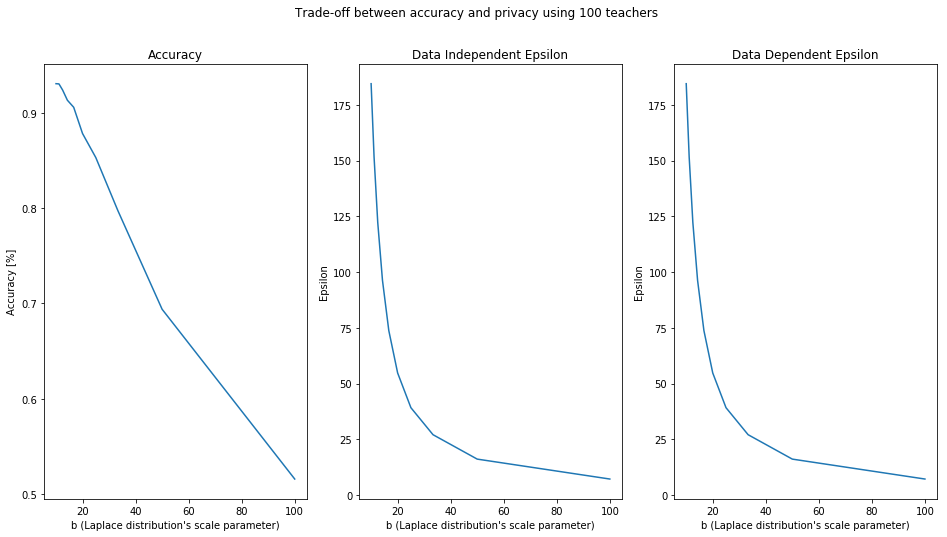

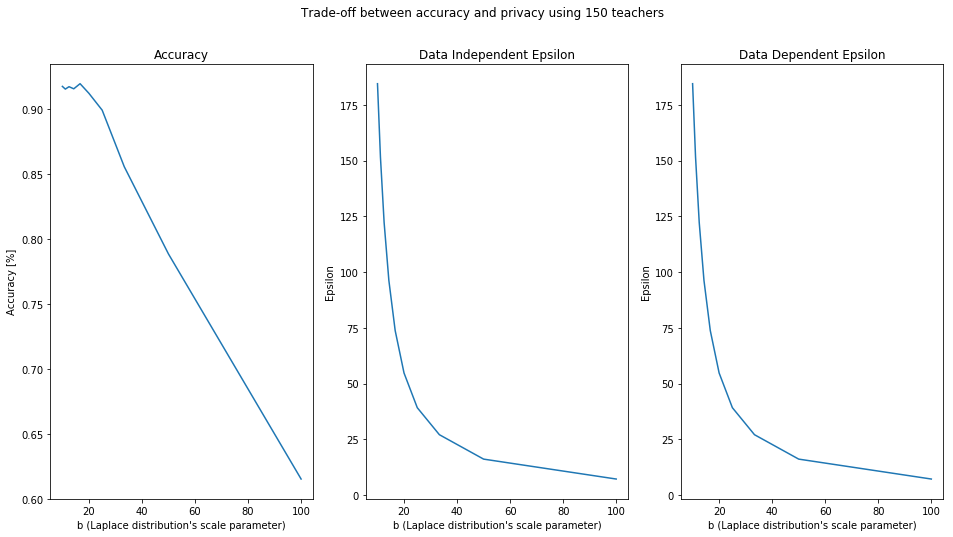

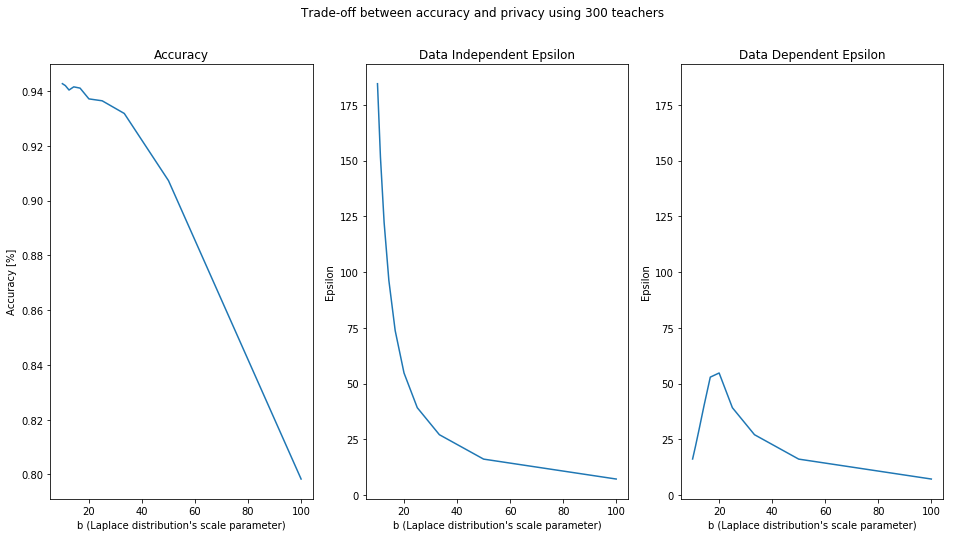

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device.type}")

hospitals = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

hospitals_preds = {}

my_hospital = ["S11", "S12", "S13"]

my_data = Mat_Dataset(["Base"], my_hospital)
my_data_loader = DataLoader(my_data, batch_size=len(my_data), shuffle=False)

class Mini_Dataset(torch.utils.data.Dataset):
  def __init__(self, samples, labels):
    self.samples = samples
    self.labels = labels

  def __len__(self):
    return self.samples.shape[0]

  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

for n_teachers in [10, 15, 30]:

  for hospital in hospitals:
    private_data = Mat_Dataset(["Base"], [hospital])
    n_images = len(private_data)
    batch_size = int(n_images/n_teachers)
    private_data_loader = DataLoader(private_data, batch_size=batch_size, shuffle=True)

    i = 0

    for samples, labels in iter(private_data_loader):
      mini_dataset = Mini_Dataset(samples, labels)
      if len(mini_dataset) < batch_size:
        continue
      mini_data_loader = DataLoader(mini_dataset, batch_size=int(len(mini_dataset)/5), shuffle=True)
      private_model = train_teacher(device, mini_data_loader)
      accuracy = 0
      private_model.to(device)
      private_model.eval()
      with torch.no_grad():

        for inputs, labels in my_data_loader:

          inputs, labels = inputs.to(device), labels.to(device)
          logps = private_model.forward(inputs)
          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
          #print(f"Accuracy {accuracy/len(my_data_loader):.3f}, Hospital: {hospital}, Teacher: {i}")
          hospitals_preds[hospital + "_" +  str(i)] = top_class
          i += 1

  hospital_p = np.hstack([hospitals_preds.get(key).cpu() for key in hospitals_preds.keys()])
  num_positions = 3

  def hospitals_vote(hospital_p, epsilon=0.1):
    new_labels = list()

    for a_measurement in hospital_p:

      label_counts = np.bincount(a_measurement, minlength=num_positions)

      beta = 1 / epsilon

      for i in range(len(label_counts)):
        label_counts[i] += np.random.laplace(0, beta, 1)

      new_label = np.argmax(label_counts)

      new_labels.append(new_label)

    return np.array(new_labels)

  accuracies = []
  data_independent_eps = []
  data_dependent_eps = []
  noises = np.arange(0.1, 0, -0.01)
  for noise_eps in noises:
    indices = hospitals_vote(hospital_p, epsilon=noise_eps)
    data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=hospital_p.transpose(), indices=indices, noise_eps=noise_eps, delta=1e-5)
    #print("Data Independent Epsilon:", data_ind_eps)
    #print("Data Dependent Epsilon:", data_dep_eps)

    tr_d = my_data[:][1]
    accuracies.append(sum(np.array(indices) == tr_d)/np.shape(np.array(indices) == tr_d)[0])
    data_dependent_eps.append(data_dep_eps)
    data_independent_eps.append(data_ind_eps)

  noises = 1/np.arange(0.1, 0, -0.01)

  # Creates two subplots and unpacks the output array immediately

  fig = plt.figure(figsize=(16,8))

  fig.suptitle(f'Trade-off between accuracy and privacy using {n_teachers*10} teachers')

  ax1 = fig.add_subplot(1, 3, 1)
  plt.plot(noises, accuracies)
  ax1.title.set_text("Accuracy")
  ax1.set_xlabel('b (Laplace distribution\'s scale parameter)')
  ax1.set_ylabel('Accuracy [%]')
  ax2 = fig.add_subplot(1, 3, 2)
  plt.plot(noises, data_independent_eps)
  ax2.title.set_text("Data Independent Epsilon")
  ax2.set_xlabel('b (Laplace distribution\'s scale parameter)')
  ax2.set_ylabel('Epsilon')
  ax3 = fig.add_subplot(1, 3, 3, sharey = ax2)
  plt.plot(noises, data_dependent_eps)
  ax3.title.set_text("Data Dependent Epsilon")
  ax3.set_xlabel('b (Laplace distribution\'s scale parameter)')
  ax3.set_ylabel('Epsilon')